In [1]:
import numpy as np
import os
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import model
import argparse
from model import Unet
import train
from torchvision import transforms
from data.dataset import get_loader

In [2]:
_CSV_FILE_TRAIN_ = './data/image_pairs.csv'
_CSV_FILE_VAL_ = './data/image_pairs_valid.csv'
_CSV_FILE_TEST_= './data/image_pairs.csv'

In [3]:
config = {}
config['data_dir'] = './data/image_toy'
config['batch_size'] = 1

In [4]:
config['n_class'] = 2
config['lr'] = 0.0005
config['model_name']='Unet'
config['weight_decay'] = 0.0001
config['lr_reduce_factor'] = 0.9
config['lr_schedule_patience'] = 10
config['max_epoch'] = 30
config['max_time'] = 3

In [5]:
device = torch.device('cuda')
model = Unet(config['n_class'])
train_epoch = getattr(train, 'Train')()
model.to(device)

print('network structure is shown:\n\n{}'.format(model))

# step 3: loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['lr_reduce_factor'],
                                                     patience=config['lr_schedule_patience'], verbose=True)

epoch_train_losses, epoch_val_losses = [], []
per_epoch_time = []

network structure is shown:

Unet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )

In [6]:
torch.cuda.empty_cache()
train_data, val_data, test_data = None, None, None
train_loader, train_data = get_loader(data_dir=config['data_dir'], csv_file=_CSV_FILE_TRAIN_, split='train', batch_size=config['batch_size'],shuffle=True, num_workers=0,max_num_samples=-1)
val_loader, val_data = get_loader(data_dir=config['data_dir'], csv_file=_CSV_FILE_VAL_, split='val', batch_size=config['batch_size'],shuffle=True, num_workers=0,max_num_samples=-1)
test_loader, test_data = get_loader(data_dir=config['data_dir'], csv_file=_CSV_FILE_TEST_, split='test', batch_size=config['batch_size'],shuffle=True, num_workers=0,max_num_samples=-1)
print("Training samples: ", len(train_data))
print("Validation samples: ", len(val_data))
print("Test samples: ", len(test_data))

t0 = time.time()
print('\n start training! \n')
time.sleep(1)
with tqdm(range(config['max_epoch'])) as t:
    for epoch in t:
        t.set_description('Epoch:{}'.format(epoch))
        start = time.time()
        epoch_train_loss, optimizer = train_epoch.train(model, optimizer, device, train_loader, epoch)
        epoch_val_loss = train_epoch.validate(model, device, val_loader, epoch)
        epoch_test_loss = train_epoch.validate(model, device, test_loader, epoch)

        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)

        t.set_postfix(time=time.time() - start, lr=optimizer.param_groups[0]['lr'], train_loss=epoch_train_loss,
                          val_loss=epoch_val_loss)
        per_epoch_time.append(time.time() - start)
        scheduler.step(epoch_val_loss)

        # Stop training if max hours exceed
        if time.time() - t0 > config['max_time'] * 3600:
            print('-' * 20)
            print("Max_time for training elapsed {:.2f} hours, so stopping".format(config['max_time']))
            break

# print training/testing information
time.sleep(1)

print("Convergence Time (Epochs): {:.4f}".format(epoch + 1))
print("TOTAL TIME TAKEN: {:.4f}s".format(time.time() - t0))
print("AVG TIME PER EPOCH: {:.4f}s".format(np.mean(per_epoch_time)))
print('Finish!')

Training samples:  4
Validation samples:  1
Test samples:  4

 start training! 



Epoch:28:  93%|█████████▎| 28/30 [01:57<00:08,  4.16s/it, lr=0.0005, time=4.15, train_loss=0.104, val_loss=0.0522] 

Epoch    28: reducing learning rate of group 0 to 4.5000e-04.


Epoch:29: 100%|██████████| 30/30 [02:06<00:00,  4.21s/it, lr=0.00045, time=4.15, train_loss=0.0756, val_loss=0.0452]


Convergence Time (Epochs): 30.0000
TOTAL TIME TAKEN: 128.2899s
AVG TIME PER EPOCH: 4.2083s
Finish!


In [7]:
for it, (img_inputs, target) in enumerate(val_loader):
    img_inputs = img_inputs.to(device)
    target = target.to(device)
    break

pred = model(img_inputs)
demo = torch.argmax(pred,dim=1)
d = demo[0].cpu().detach().numpy()

In [8]:
d.sum()

5363

In [9]:
numerator = 2 * torch.sum(tmp * target)
denominator = torch.sum(pred + target)
loss = 1 - (numerator + 1) / (denominator + 1)

In [9]:
import h5py
import numpy as np
import os, sys
import numpy as np
from PIL import Image

def hdf_2_array(filename):
    hdf = h5py.File(filename,'r')
    data = hdf['MDF']['images']['0']['image']
    arr = np.array(data)
    return arr

def arr_to_img(test):
    formatted = (test * 255 / np.max(test)).astype('uint8')
    img = Image.fromarray(formatted)
    return img

In [10]:
filename = './data/image_toy/20190917_platelet_3K_set10__bin2_bin2_Z-245_image.hdf'
t_filename = './data/image_toy/20190917_platelet_3K_set10__bin2_bin2_Z-245_densegranule.hdf'
truth = hdf_2_array(t_filename)
seg = hdf_2_array(filename)

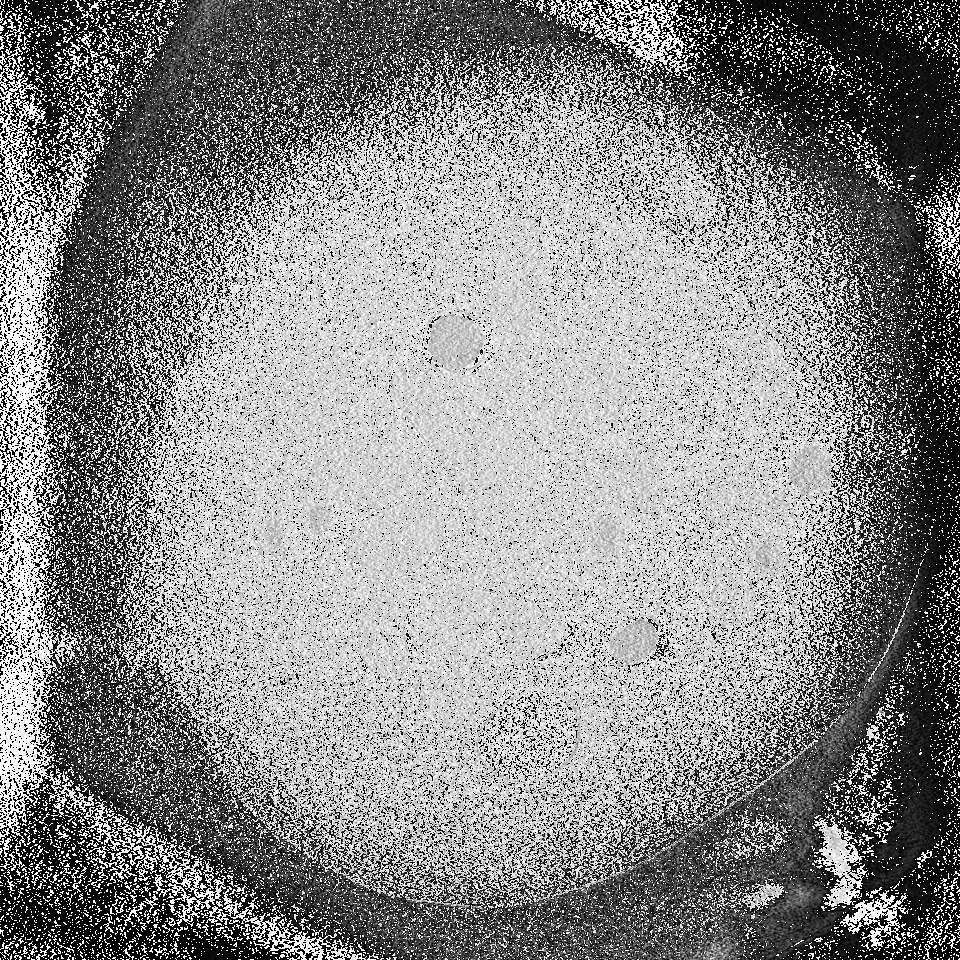

In [11]:
arr_to_img(seg)

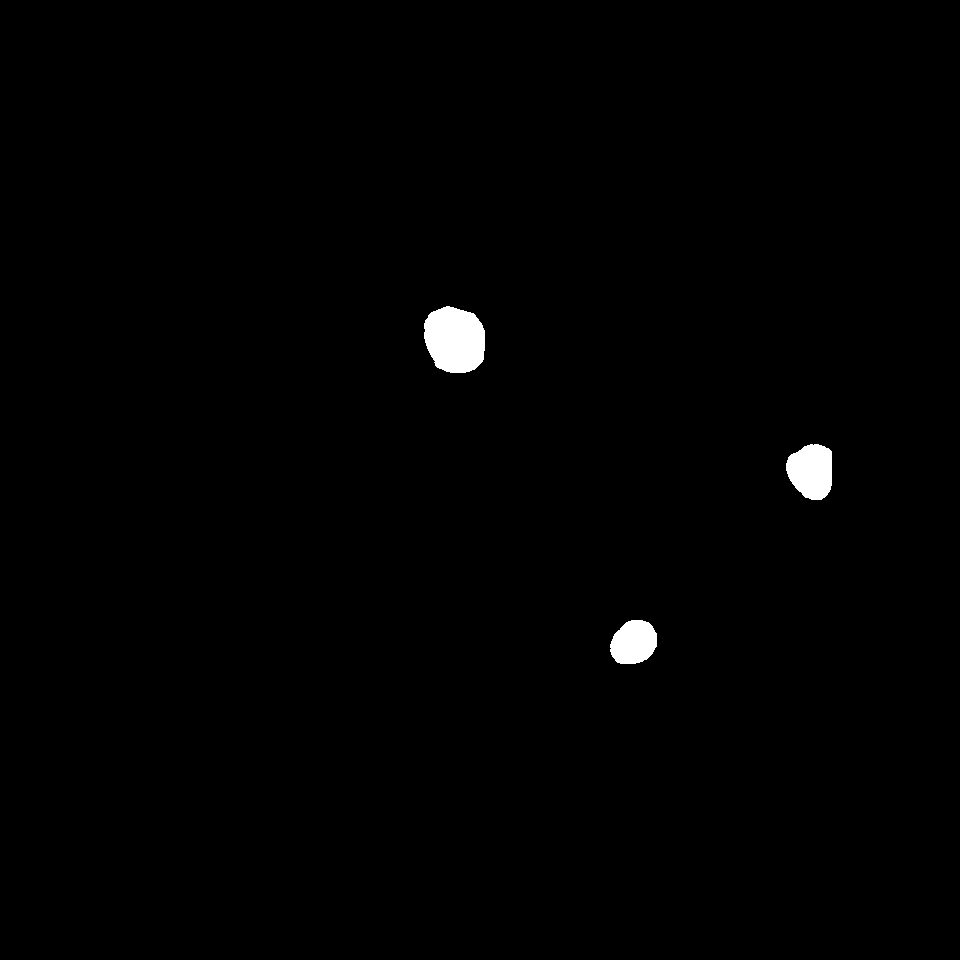

In [12]:
arr_to_img(truth)

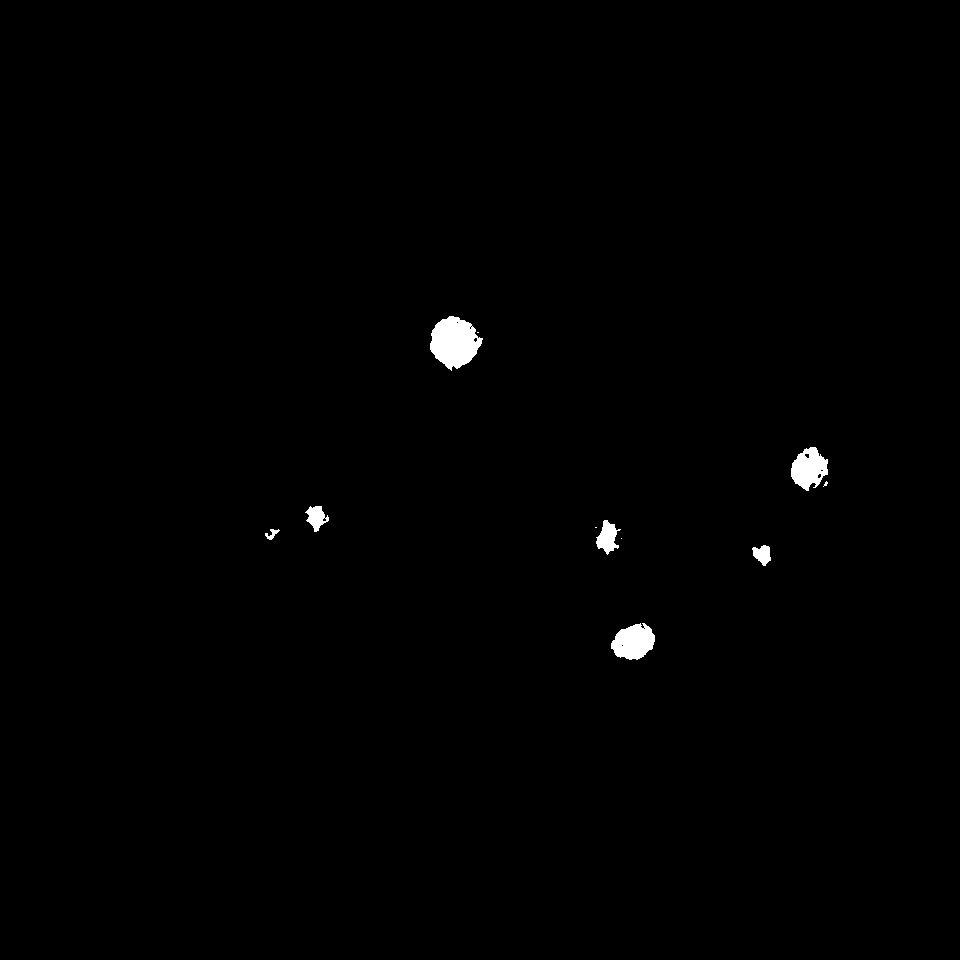

In [13]:
arr_to_img(d)